# Tutorial: Training models in scikit-learn

In this notebook we will show how we train models in scikit-learn using example of polynomial regression. We will learn how to
* Split the data into training set and test set
* Fit a polynomial model to the training data
* Tune the the hyperparameter polynomial degree using cross-validation
* Evaluate performance on the test set

This tutorial complements the Lecture material
__Machine Learning Basics__ 
__Part IV: Training Machine Learning Models__

## Generate the data

We will generate the training data from a quadratic model $y=2x^2+4x+5$ by generating random features from uniform distribution for the interval $[-3,3]$ using `np.random.rand` and adding Gaussian noise with $\sigma=3$ to the target values using `np.random.randn`.

Run the code bellow to generate your dataset. Note that
* Feature matrix is given in the variable `X`
* Target vector is given in variable `y`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# DEFINE THE TRUE MODEL

def TrueModel(x):
    return 2*x**2+4*x+5

# GENERATE RANDOM SAMPLES

# to keep the random samples same at every run
gen = np.random.RandomState(40)
# generate 100 random samples
n=100
X = 6*gen.rand(n)-3
# generate noise for each sample
noise = 3*gen.randn(n)
# generate noisy samples
y = TrueModel(X) + noise

# convert features X into a 2D array
X = X.reshape(-1,1) 

__Activity 1:__ Write code to print out the dimensions of the feature matrix X and target vector y. How many features and samples we have?

In [12]:
# Print dimensions of feature matrix and target vector
print('Feature Matrix:', X.shape)
print('Target Vector:', y.shape)

# Print number of features and samples 
print('Samples: ',X.shape[0])
print('Features: ',X.shape[1])

Feature Matrix: (100, 1)
Target Vector: (100,)
Samples:  100
Features:  1


__Activity 2:__ Plot the generated samples. *Hint:* use `plt.plot`

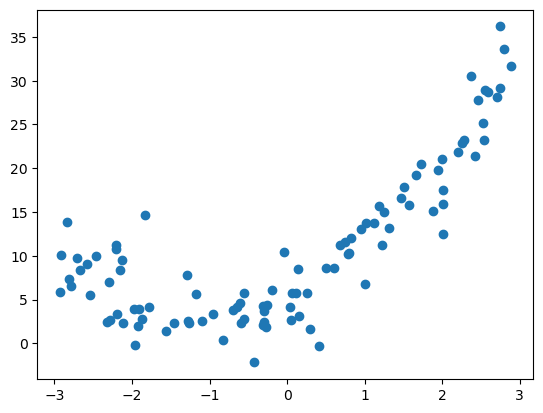

In [16]:
plt.plot(X,y,'o')

## Split the data to training and test set

Scikit learn offers a function `sklearn.model_selection.train_test_split` to perform the splitting of the dataset. A common pattern is to keep 80% of the data for training and use 20% for testing. This can be set using an option `test_size`. Splitting is random, so if we wish to keep the same split at every run we can use parameter `random_state`.

Finally, to create a representative test set, we can use the `stratify` parameter. In this example we will split the data into 7 bins by rounding the feature values, and stratify the test set to have the same proportion of the data from each bin as the training set.

__Activity 3:__ Play with parameter `test_size` to see different splits

Text(0, 0.5, 'Target value')

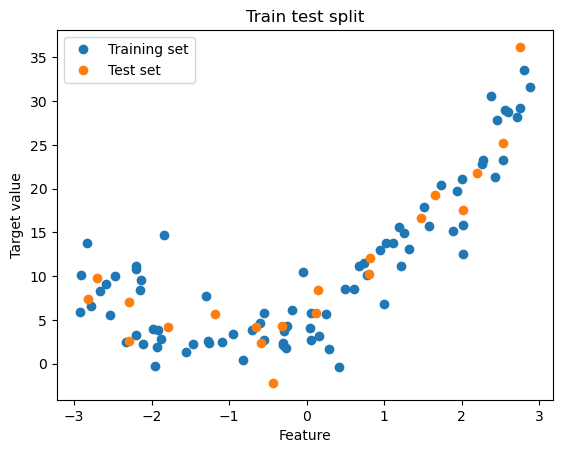

In [29]:
from sklearn.model_selection import train_test_split

# create bins for the target values
bins = np.round(X)

# perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify = bins, random_state=42)

# plot the training and test data
plt.plot(X_train,y_train,'o',label='Training set')
plt.plot(X_test,y_test,'o',label='Test set')
plt.legend()
plt.title('Train test split')
plt.xlabel('Feature')
plt.ylabel('Target value')

## Fitting a polymomial model

Scikit-learn does not implement a polynomial regression model. Instead the polynomial regression is performed in two steps:
1. Polynomial feature transformation - a __transformer__ object `PolynomialFeatures` transforms each feature $x$ into a feature vector $(1,x,x^2,...,x^M)$, where polynomial degree $M$ is defined by setting parameter `degree` 
2. Performing multivariate linear regression - a __regressor__ object `LinearRegression` fits the model 
$y=w_0x_0+x_1w_1+...+x_Mw_M$ to the data.

Note that if we combine these two steps, we will have $x_j=x^j$ and therefore create a polynomial model $y=w_0+w_1x+...+w_Mx^M$

The code bellow demonstrates how we can fit the 2nd order polynomial model to the training set and evaluate it on the test set. 

In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# create polynomial features object of second degree
M=15
poly_features = PolynomialFeatures(degree=M)

# transform training features (note conversion to 2D array)
X_train_poly = poly_features.fit_transform(X_train)

# Create and fit multivariate linear regression model
# We do not need intercept, because the first feature is 1
model = LinearRegression(fit_intercept=False)
model.fit(X_train_poly,y_train)

# Evaluate the model on the test set
X_test_poly = poly_features.fit_transform(X_test)
r2_test = model.score(X_test_poly,y_test)
print('R2 score on test set is ', round(r2_test,2))

R2 score on test set is  0.91


### Plot the fitted polynomial model

__Activity 4:__ Fill in the code bellow to plot the second order polynomial model that we just fitted. Then change the polynomial degree in the cell above, and rerun both cells to see how the model changes.

Text(0, 0.5, 'Target value')

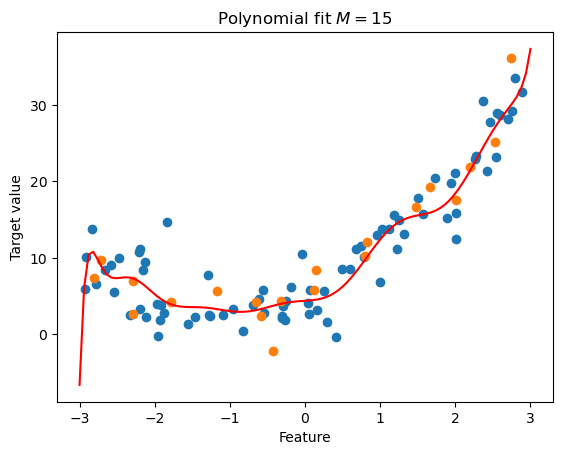

In [41]:
# plot the training and test data
plt.plot(X_train,y_train,'o')
plt.plot(X_test,y_test,'o')


# define the feature space
X_curve=np.linspace(-3,3,100).reshape(-1, 1)

# Perform the polynomial feature transformation of X_curve
X_curve_poly = poly_features.fit_transform(X_curve)

# Predict target values using X_curve_poly
y_curve = model.predict(X_curve_poly)

# plot the curve
plt.plot(X_curve,y_curve,'r')

# annotate the plot
plt.title('Polynomial fit $M={}$'.format(M))
plt.xlabel('Feature')
plt.ylabel('Target value')

## Setting up a model pipeline

It is not always convenient to perform several steps for model training, prediction and evaluation. In particular if the model becomes an input to another `sklearn` object, such as hyperparameter search using cross-validation that we will introduce below, the steps need to be unified in a single object.

Scikit-learn implements a class `sklearn.pipeline.Pipeline` to join multiple __steps__ into one model. `Pipeline` implements methods `fit`, `predict`, `score` and others to offer a unified API with other sklearn objects.

In the code bellow we will demonstrate how to join the polynomial feature transformation and multivariate linear regression into a single model. 

In [42]:
from sklearn.pipeline import Pipeline

# Polynomial regression model is created as a 'pipeline'
# combining creation of features (1,x,x^2,...) followed
# by multivariate linear regression
pipeline = Pipeline((
("poly_features", PolynomialFeatures(degree=2)),
("lin_reg", LinearRegression(fit_intercept=False)) ))

# Fit the model using features and labels
pipeline.fit(X_train, y_train)

# calculate performance
r2_test = pipeline.score(X_test,y_test)
print('R2 score on test set is ', round(r2_test,2))

R2 score on test set is  0.91


Let's look in detail at the syntax for creating the pipelines. It is in the form `Pipeline(steps)`, where the input argument `steps` is a list of transforms and models to be chained, in the order with which they need to be called. Each step is described by a tuple `(name, model)`, where `name` is a string chosen by the user and `model` is a `sklearn` object.

To access the original objects joint in a `Pipeline` we use attribute `Pipeline.named_steps`. For example, the linear regression object defined in the cell above can be accessed as: 

In [43]:
# access LinearRegression object
pipeline.named_steps["lin_reg"]

LinearRegression(fit_intercept=False)

and coefficient of the linear regression $w_0,...,w_k$ can be accessed as 

In [44]:
# access coefficient of the LinearRegression object
pipeline.named_steps["lin_reg"].coef_

array([4.98164783, 3.7729512 , 1.90766111])

We see that we have recovered a model $y=5+3.8x+1.9x^2$ which is fairly close to our true model.

__Activity 5:__ Complete the code bellow to print out polynomial degree

In [47]:
# access polynomial degree of the PolynomialFeatures object
pipeline.named_steps["poly_features"].degree

2

## Cross-validation

Even if we stratify our test set, it is not guaranteed that it is representative and the performance may vary every time we create a different split. More robust way is to perform cross-validation, where we split the data into $k$ groups (folds), and each fold will be used to measure performance exactly once, while remaining data are used to fit the model. Average performance over the $k$ folds will be much more robust. If there are no hyperparameters to tune, cross-validation can be used directly to measure the performance of the model.

In scikit-learn cross validation is called using `cross_val_score(estimator, X, y)` with arguments
* `estimator:` the model to be fit
* `X:` the feature matrix
* `y:` optional target values or labels for supervised models
- `cv:` optional argument that defines number of folds. 

The model returns an array with scores from each fold. 

__Activity 6:__ Perform cross-validation for polynomial models of different degrees and observe how the average $R^2$ score changes. To do that you can modify the polynomial degree and rerun the cell above multiple times.

In [70]:
from sklearn.model_selection import cross_val_score
    
# define the model
pipeline = Pipeline((
("poly_features", PolynomialFeatures(degree=2)),
("lin_reg", LinearRegression(fit_intercept=False)),))

# perform 5-fold cross-validation
scores = cross_val_score(pipeline, X, y, cv=5)

# print scores
print('Scores',np.around(scores,2))
print('Cross-validated R2 score: mean {}, standard deviation {} '.format(round(scores.mean(),3),round(scores.std(),3)))

Scores [0.84 0.88 0.88 0.9  0.87]
Cross-validated R2 score: mean 0.874, standard deviation 0.022 


## Hyperparameter search using cross-validation

Finally we will show how we can automatically find the optimal hyperparameters in scikit-learn. One of the most common way is to train a model for each hyper-parameter value and measure its performance using cross-validation. This approach is implemented in `sklearn.model_selection.GridSearchCV`. 
 
First we need to create the grid search object using `GridSearchCV(estimator, param_grid)` with arguments:
* `estimator:` the model to be fitted
* `param_grid:` a dictionary, with parameter names as keys, and parameter values as lists
* `cv:` optional parameter to determine the number of folds

We will now find the optiomal polynomial degree automatically, using the `GridSearchCV`. First we need to define our parameter grid dictionary. Because we have a `Pipeline` object, the parameter name is combined of the step name `"poly_features"` and parameter name `"degree"` which are joined by two underscores `__`.

In [ ]:
# propose a range of possible values for the polynomial degree
degrees = range(1,20)

# define parameter dictionary
# because the model is a pipeline, the name of the parameter is composed
# of name of the step and parameters name joint by a double underscore
parameters = {"poly_features__degree": degrees}

Next we create the `GridSearchCV` object and run the hyperparameter optimisation using method `fit`, which is performed on the training set. The chosen polynomial model can be accessed using variable `best_estimator_`

In [ ]:
from sklearn.model_selection import GridSearchCV

# create grid search object
grid_search = GridSearchCV(pipeline, parameters,cv=5)

# perform the search over all hyperparameter values
grid_search.fit(X_train, y_train)

# This is the chosen model
best_model = grid_search.best_estimator_ 

We can also access the chosen polynomial, and the best R2 score identified through cross-validation.

In [ ]:
# Degree of the best model
best_degree = best_model.named_steps['poly_features'].degree
print('The best polynomial degree ',best_degree)

# best score
best_score = grid_search.best_score_
print('The best cross-validated R2 score on training set is ',round(best_score,2))

## Evaluate performance on test set

We can evaluate the performance on the test set directly using a trained `GridSearchCV` by calling its method `score`. It will return the score of the model with the best hyperparameter setting identified during the search and fitted to the whole training set.

In [ ]:
r2 = grid_search.score(X_test,y_test)
print('R2 score on test set is: ', round(r2,2))

## Exercise 5

In this exercise you will find the best polynomial fit to noisy data.

We will load the data 'noisy_data.csv' using `pandas`. The file contains two columns:
* column zero contains features `X`
* column one contains target values `y`

Run the code bellow to create `X` and `y` and plot the data.

In [ ]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# load data
import pandas as pd
df = pd.read_csv('datasets/noisy_data.csv')
X = df.values[:,0].reshape(-1,1)
y = df.values[:,1]

# print data
plt.plot(X,y,'o')
plt.title('Noisy data')
plt.xlabel('Feature')
plt.ylabel('Target value')

Your task is to fit a polynomial model to the data. Perform following steps:
* Perform stratified train-test split 
* Create a polynomial model using `Pipeline`
* Use `GridSearchCV` to find the optimal polynomial degree and print out the best cross-validated score
* Calculate performance on the test set
* Plot the fitted model
* Print out the coefficients of the model

Can you work out what was the underlying polynomial model? (*Hint: the coefficients were whole numbers*)

In [ ]:
# STRATIFIED TRAIN TEST SPLIT
bins = np.round(X)
X_train, X_test, y_train, y_test = None

In [ ]:
# CREATE POLYNOMIAL MODEL
pipeline = None

In [ ]:
# CREATE PARAMETER GRID
parameters = None

In [ ]:
# OPTIMISE HYPERPARAMETERS
# Create 
grid_search = None

# Fit GridSearchCV object


# extract the selected model
best_model = None

# print out best score and chosen polynomial degree
print('The best cross-validated R2 score on training set is ',round(grid_search.best_score_,2))
print('The best polynomial degree ',best_model.named_steps["poly_features"].degree)

In [ ]:
# CALCULATE PERFORMANCE ON TEST SET
r2 = None
print('R2 score on test set is ', round(r2,2))

In [ ]:
# PLOT THE FITTED MODEL

# generate the feature space
x_curve=None

# predict the targets
y_curve=None

# plot the training data


# plot the test data


# plot the model curve


# annotate
plt.title('Polynomial fit')
plt.xlabel('Feature')
plt.ylabel('Target value')

In [ ]:
# COEFFICIENTS OF THE MODEL
coef = None
print('Coefficients: ',np.around(coef))

The original model is $y=?$

*Note: Splitting of training and test set is random, so different solutions are possible. From the shape of the dataset we can judge that the underlying polynomial was cubic. If you obtain polynomial of higher degree, try to re-run your code until you get a cubic polynomial. That will help you to work out true model coefficients.*